In [1]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from functions import util
import json

import warnings
warnings.filterwarnings("ignore")

In [3]:
with open('./hopsworks-api-key.txt', 'r') as file:
     os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1157273
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


In [4]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

In [5]:
# Select features for training data.
selected_features = air_quality_fg.select(['pm25']).join(weather_fg.select_all(), on=['city'])
selected_features.show(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.29s) 


,pm25,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,NaN,2013-12-31 00:00:00+00:00,11.589584,0.0,11.609651,2.566667,guangzhou
1,179.0,2014-01-01 00:00:00+00:00,12.233335,0.0,9.064569,87.111458,guangzhou
2,179.0,2014-01-02 00:00:00+00:00,15.418752,0.0,8.049845,76.328690,guangzhou
3,196.0,2014-01-03 00:00:00+00:00,17.520834,0.0,13.441071,355.061920,guangzhou
4,186.0,2014-01-04 00:00:00+00:00,14.320831,0.0,18.511143,11.560085,guangzhou
5,170.0,2014-01-05 00:00:00+00:00,13.872918,0.0,10.086427,103.221291,guangzhou
6,203.0,2014-01-06 00:00:00+00:00,16.918749,0.4,13.905509,130.822815,guangzhou
7,169.0,2014-01-07 00:00:00+00:00,17.718748,2.6,13.797913,121.128624,guangzhou
8,152.0,2014-01-08 00:00:00+00:00,13.683331,0.0,22.668568,8.815579,guangzhou
9,123.0,2014-01-09 00:00:00+00:00,13.302082,0.0,18.032370,26.564972,guangzhou


In [6]:
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv',
    description="weather features with air quality as the target",
    version=1,
    labels=['pm25'],
    query=selected_features,
)

In [7]:
start_date_test_data = "2024-10-15"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [9]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (8.33s) 


In [10]:
X_train

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2013-12-31 00:00:00+00:00,11.589584,0.0,11.609651,2.566667,guangzhou
1,2014-01-01 00:00:00+00:00,12.233335,0.0,9.064569,87.111458,guangzhou
2,2014-01-02 00:00:00+00:00,15.418752,0.0,8.049845,76.328690,guangzhou
3,2014-01-03 00:00:00+00:00,17.520834,0.0,13.441071,355.061920,guangzhou
4,2014-01-04 00:00:00+00:00,14.320831,0.0,18.511143,11.560085,guangzhou
...,...,...,...,...,...,...
3888,2024-10-10 00:00:00+00:00,25.139582,0.0,15.244842,13.399688,guangzhou
3889,2024-10-11 00:00:00+00:00,25.383333,0.0,11.866355,71.452492,guangzhou
3890,2024-10-12 00:00:00+00:00,25.720831,0.0,8.777653,125.090019,guangzhou
3891,2024-10-13 00:00:00+00:00,26.954165,0.0,11.196232,107.482460,guangzhou


In [11]:
X_test

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
3893,2024-10-15 00:00:00+00:00,26.585413,5.199999,14.205182,36.253937,guangzhou
3894,2024-10-16 00:00:00+00:00,25.914587,4.300000,15.568700,39.717060,guangzhou
3895,2024-10-17 00:00:00+00:00,26.968752,0.200000,15.326447,119.766617,guangzhou
3896,2024-10-18 00:00:00+00:00,26.381248,0.300000,9.703319,29.078236,guangzhou
3897,2024-10-19 00:00:00+00:00,27.474998,0.200000,20.849718,17.786936,guangzhou
3898,2024-10-20 00:00:00+00:00,25.797913,0.200000,18.044046,24.697830,guangzhou
3899,2024-10-21 00:00:00+00:00,25.995836,0.000000,16.244936,16.781546,guangzhou
3900,2024-10-22 00:00:00+00:00,24.985418,0.000000,29.395159,7.700455,guangzhou
3901,2024-10-23 00:00:00+00:00,21.889582,0.000000,27.595825,7.277298,guangzhou
3902,2024-10-24 00:00:00+00:00,22.029165,0.000000,26.820602,4.775386,guangzhou


In [12]:
# Drop the index columns - 'date' (event_time) and 'city' (primary key)

train_features = X_train.drop(['date', 'city'], axis=1)
test_features = X_test.drop(['date', 'city'], axis=1)

In [13]:
y_train.fillna(y_train.median(), inplace=True)
y_train

,pm25
0,85.0
1,179.0
2,179.0
3,196.0
4,186.0
...,...
3888,69.0
3889,83.0
3890,120.0
3891,115.0


In [14]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(train_features, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [15]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 1012.9546
R squared: -0.6458003990659107


In [16]:
df = y_test
df['predicted_pm25'] = y_pred

In [17]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)

,pm25,predicted_pm25,date
3893,136.0,69.791946,2024-10-15 00:00:00+00:00
3894,86.0,77.429649,2024-10-16 00:00:00+00:00
3895,65.0,97.834732,2024-10-17 00:00:00+00:00
3896,89.0,105.601982,2024-10-18 00:00:00+00:00
3897,95.0,83.975739,2024-10-19 00:00:00+00:00


In [18]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

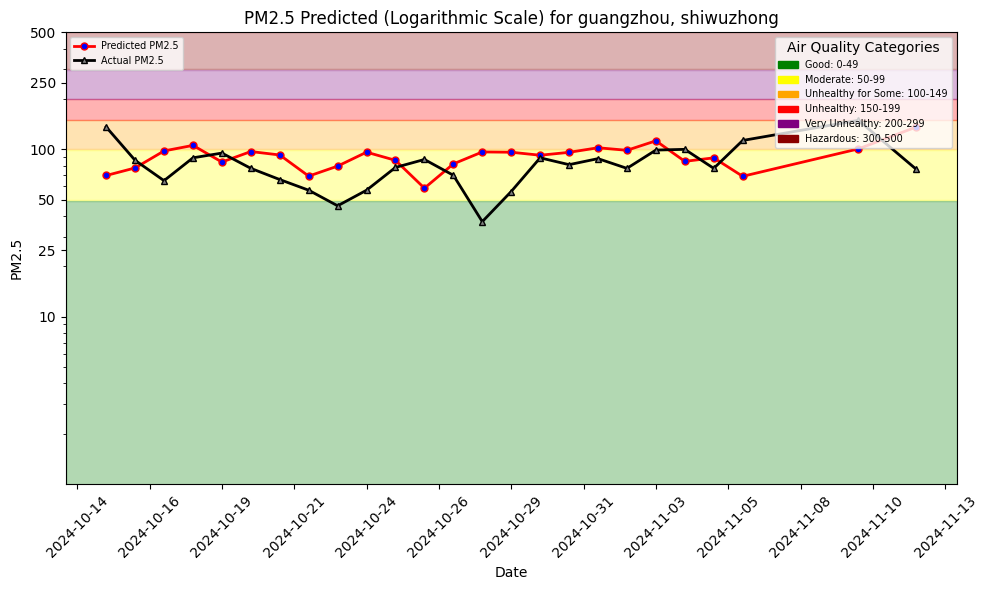

In [19]:
file_path = images_dir + "/pm25_hindcast.png"
plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
plt.show()

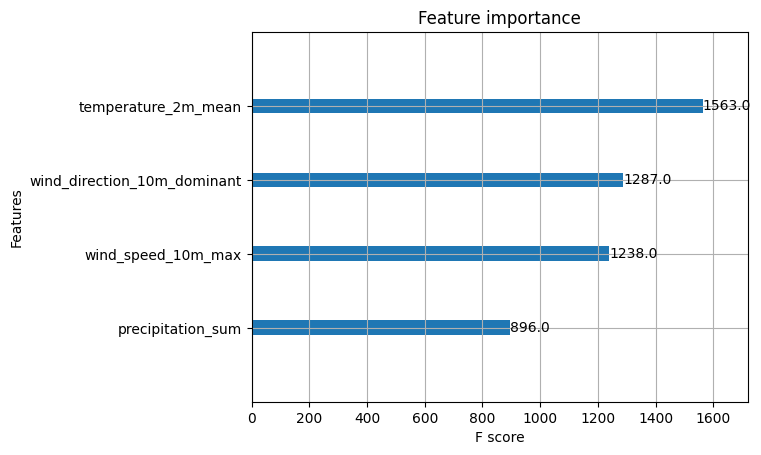

In [20]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor, max_num_features=4)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

In [21]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [22]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [23]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [24]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model", 
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/561849 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/20200 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/67650 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/125 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/645 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1157273/models/air_quality_xgboost_model/2


Model(name: 'air_quality_xgboost_model', version: 2)